In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [4]:
#Downloading cifar-10 from Dive Into Deep Learning library
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip', '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

#For full data set, demo = False, otherwise a smaller-scale sample is used
demo = True


if demo:
    #Small-scale dataset
    data_dir = d2l.download_extract('cifar10_tiny')
    
else:
    #Full dataset on local machine, downloaded from Kaggle
    data_dir = '../entire-cifar-10'


In [5]:

def read_csv_labels(fname):
    ''' Creates a dictionary with class names as keys, and the list of 
    corresponding file names that are under that class as the values
    
    'fname' = name of csv file with each image file and its ground truth class
    Output: Dictionary of all classes, and then all image file names under the correct class
    '''
    with open(fname, 'r') as f:
        # Skipping the csv header row with column names
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# training examples:', len(labels))
print('# of classes:', len(set(labels.values())))

# training examples: 1000
# of classes: 10


In [6]:
def copyfile(filename, target_dir):
    """Copy a file into a target directory."""
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

def reorg_train_valid(data_dir, labels, valid_ratio):
    '''Creating validation set from original training data
    
    'data_dir' = file path to the training and testing directories
    'labels' = (dictionary), keys are class names and values are image file names 
    'valid_ratio' = fraction of training set to become validation set
    '''
    # Finding number of images under class with fewest values in training dataset
    n = collections.Counter(labels.values()).most_common()[-1][1]
    
    # The number of examples per class for the validation set
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                    'train_valid', label))
        
        if label not in label_count or label_count[label] < n_valid_per_label:
            # File goes into validation directory
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            # File goes into train directory
            copyfile(fname, os.path.join(data_dir, 'train_valid_test',
                                         'train', label))
            
    return n_valid_per_label

def reorg_test(data_dir):
    '''Organizing the testing set for data loading during prediction.'''
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(os.path.join(data_dir, 'test', test_file),
                os.path.join(data_dir, 'train_valid_test', 'test', 'unknown'))
    


In [7]:
def reorg_cifar10_data(data_dir, valid_ratio):
    # Invoke read_csv_labels
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    # Invoke reorg_train_valid
    reorg_train_valid(data_dir, labels, valid_ratio)
    # Invoke reorg_test
    reorg_test(data_dir)
    


In [8]:
# SETTING PARAMETERS FOR DATA USE #
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [9]:
'''
ADDRESSING OVERFITTING WITH:
1) Image Augmentation - randomly flips/rotates images throughout training to better
    adapt to unkown images
2) RGB Standardization - normalizes color images by changing RGB values to have
    zero mean, reducing effect of lighting differences in images
'''
## Training Images Augmenation (Multiple adjustments) ##
transform_train = torchvision.transforms.Compose([
    # Scale the image up to a square of 40 pixels in both height and width
    torchvision.transforms.Resize(40),
    
    # Randomly crop a square image to produce a small square of 0.64 to 1 times
    # the area of the original image, and then scaled back up to a 32x32 image
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                   ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    
    # Standardize each channel of the image
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     # ^^ Mean of Red, Blue, Green across dataset ^^
                                     [0.2023, 0.1994, 0.2010])])
                                     # ^^ Standard Deviation of Red, Blue, Green across dataset ^^
                                    

## Testing Images Augmentation (Only RGB Standardization) ##
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [10]:
'''
READING THE DATASET

The organized dataset with raw image and label is read into the train,
valid, train_valid (train + valid), and test sets

 * Train * = set of images model will learn from
 * Valid * = set of images used to evaluate performance during hyperparameter tuning
 * Train_valid * = combination of train and valid sets, used to train model before final prediction
 * Test *  = set of unkown images never seen by the model, used to evaluate trained model performance

'''
# Establishing train and train_valid, using aggressive transform function
train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

# Establishing valid and test, using simple transform function
valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

In [11]:
'''
CREATING DATA ITERATORS

Description --> These allow for each dataset (train, valid, train_valid, test) to be taken
    in batch sizes, as specified in earler declaration (Cell 6), and iterated through the
    set in this way
'''
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)

In [12]:
'''
DEFINING THE MODEL
'''
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction="none")


In [13]:
'''
DEFINING THE TRAINING FUNCTION
'''
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    
    ## Commented out original line (below) and had to adjust for just CPU usage. No GPU's
    #net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    devices = [torch.device('cpu')]
    print(devices)
    net = net.to(torch.device('cpu'))
    

    
    # Loops over training data set for # of epochs
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
        
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')
    


train loss 0.564, train acc 0.806, valid acc 0.422
19.5 examples/sec on [device(type='cpu')]


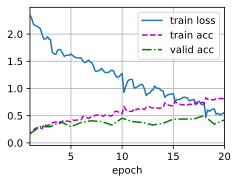

In [12]:
'''
PERFORMING TRAINING AND VALIDATION
(Very compute heavy, takes 5 - 10 minutes to run)
'''
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, get_net()
net(next(iter(train_iter))[0])
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
      lr_decay)